# Predicting the Lead via k-nn

# Summary of findings
## Initial considerations
(_some of these insights are taken from_ https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/)

In K-nn, prediction is based exclusively on distance between datapoints of the training set.

No information about relative importance of variables is integrated in the model (the 'model' is the whole training dataset). As K-nn is non-parametric, it has no assumptions about the functional form of the problem.

KNN works well with a small number of input variables, but struggles when the number of inputs is very large. As the number of dimensions increases the volume of the input space increases at an exponential rate.
## The general process
* Find which might be the most relevant features (via a correlation matrix with the target, but also through trial and error, and combining relevant features in single values)
* With the stronger candidates, do gridsearch cross-validation with repeated stratified k-fold to validate findings, and tune hyper-parameters.
    * After including some of the most relevant features (up to 4 or 5), results seem to start to decline, or add very little.
    * Include a pipeline scaling the selected features, as k-nn is very sensitive to differences in distances.
    * As including many parameters to tune (a range of leaf-sizes, different distance methodologies) is computational heavy (can take up to 15+ minutes each run), anotate the most common best parameters (leaf-size=1, p=1), k-number between 5 and 60, and subsequently run with these ones. Only do again a bigger grid search to double-check at the end.
* Process outliers, and check carefully (by trial and error with different methods, on different features, and different tuning parameters), which give better end results.
    * As K-nn relies on the training data to make predictions, be careful that the outlier method doesn't remove so many records.

# 1. Import libraries and load the data

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns # For nice-looking plots (and co-variance matrix)

import sklearn.preprocessing as skl_pre
import sklearn.ensemble as skl_ens
import sklearn.covariance as skl_cv
import sklearn.svm as skl_sv
import sklearn.model_selection as skl_ms
import sklearn.neighbors as skl_nb
import sklearn.base as skl_ba
import sklearn.metrics as skl_me
import sklearn.pipeline as skl_pl

In [2]:
# Load train dataset
url = 'data/train.csv'
data = pd.read_csv(url)

### About noise in the data

* Entries where 'Number words female' is 0, show invariably to be led by Female.
* Entries where 'Number words male' is 0, show invariably to be led by Male.

From the discussion thread, the teaching assistant says:

_"it is possible to use this information as a valuable feature for the model in this particular case"_

This hints in using it as a special rule for prediction. However, for the moment, while we tune the models, I would suggest dropping these values as they add noise

In [3]:
# Dropping 0-word entries

# Get indexes for which the number of words of female or male is 0
dropIndex = data[ (data['Number words female'] == 0) | (data['Number words male'] == 0) ].index

# Delete the rows from the dataset
data.drop(dropIndex , inplace=True)

# 2. First look at the most correlated features
We make a correlation matrix to see which features are more related with the Lead gender. For this we turn the Lead gender into a dummy variable to have a numeric indicator (1 or 0).

From this, we get that the most co-related features with the Lead's gender are: `Number of female actors`, `Number of male actors`, `Age Lead`, `Age Co-Lead`, `Difference in words lead and co-lead`

In [4]:
data_w_dummies = pd.get_dummies(data, columns=['Lead']).copy()

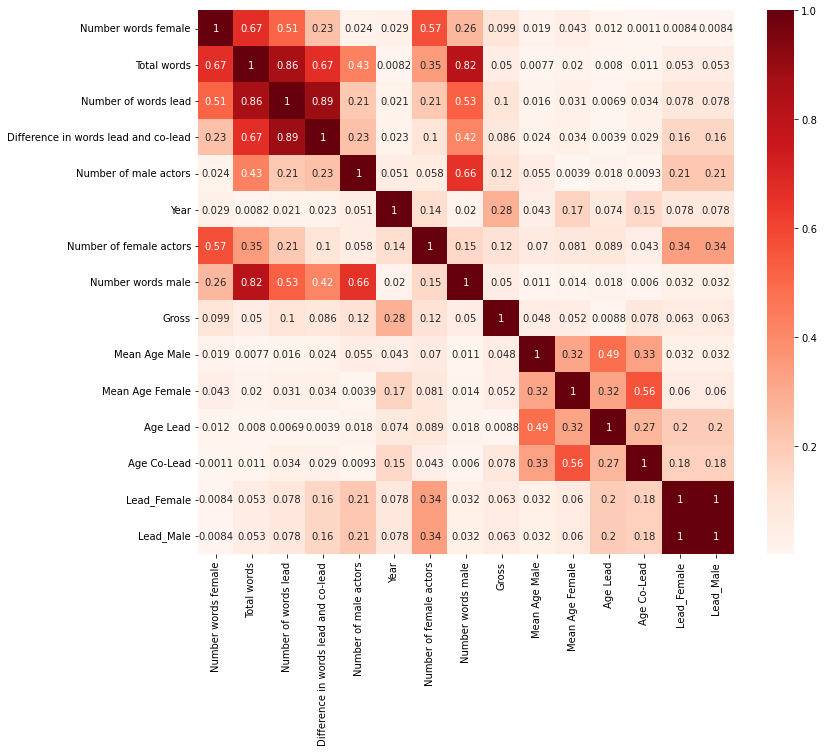

In [5]:
# Correlation heatmap (using Pearson correlation)
plt.figure(figsize=(12,10))
correlation = data_w_dummies.corr().abs()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds) # Correlation heatmap using Seaborn
plt.show()

In [6]:
# Sort features by correlation to Lead_Female
cor = data_w_dummies.corr()['Lead_Female'].abs()
cor.sort_values(ascending=False)

Lead_Female                             1.000000
Lead_Male                               1.000000
Number of female actors                 0.340337
Number of male actors                   0.210892
Age Lead                                0.195008
Age Co-Lead                             0.177974
Difference in words lead and co-lead    0.159559
Number of words lead                    0.077670
Year                                    0.077615
Gross                                   0.063485
Mean Age Female                         0.059771
Total words                             0.053008
Number words male                       0.032493
Mean Age Male                           0.032424
Number words female                     0.008421
Name: Lead_Female, dtype: float64

# 3. Run of gridsearch cross-validation with repeated stratified k-fold to validate features, and tune hyper-parameters

## Function with the general model
* At the beginning, we create a pipeline with a standard scaler, as for k-nn it is important to scale the features.
* We define which hyperparameters we want to tune on (leaf_size, k number, p number)
* We perform a repeated stratified K-fold cross-validation, to reduce variance/overfitting, while maintaining the label representation among training sets
* We us GridSearchCV to bring all together and find the best combination of configurations

In [7]:
# Function for running the general model
def run_model(X, y, n_neighbors=list(range(5,50)), scaler=True, leaf_size=[1], p=[1, 2], n_splits=10, n_repeats=5, random_state=10):

    # Create pipeline with scaler for preprocessing
    if scaler:
        pipeline = skl_pl.make_pipeline(skl_pre.StandardScaler(), skl_nb.KNeighborsClassifier())
    else:
        pipeline = skl_pl.make_pipeline(skl_nb.KNeighborsClassifier())

    # Convert hyperparameters to dictionary
    # Note that pipeline hyper-parameters need to be specified as <step name>__<hyper-parameter name>
    hyperparameters = dict(kneighborsclassifier__leaf_size=leaf_size, 
                           kneighborsclassifier__n_neighbors=n_neighbors, 
                           kneighborsclassifier__p=p)

    cv = skl_ms.RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)

    #Use GridSearch
    grid = skl_ms.GridSearchCV(pipeline, hyperparameters, scoring='accuracy', cv=cv, n_jobs=-1)

    #Fit the model
    results = grid.fit(X,y)

    return results

## First test the model with all the features, without scaling

In [8]:
X_all = data_w_dummies.iloc[:,:-2].copy()
y_all = data_w_dummies['Lead_Female'].copy()
baseline_results = run_model(X_all, y_all, scaler=False)
print("Best score: ", baseline_results.best_score_)
print("Best parameters: ")
baseline_results.best_params_

Best score:  0.7984274898078041
Best parameters: 


{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 6,
 'kneighborsclassifier__p': 2}

In [9]:
print("Std deviation of best result: ", 
      baseline_results.cv_results_['std_test_score'][baseline_results.best_index_] )

Std deviation of best result:  0.021575327721048053


## Test the model with all the features, with scaling

In [10]:
X_all = data_w_dummies.iloc[:,:-2].copy()
y_all = data_w_dummies['Lead_Female'].copy()
baseline_results = run_model(X_all, y_all, scaler=True)
print("Best score: ", baseline_results.best_score_)
print("Best parameters: ")
baseline_results.best_params_

Best score:  0.8063172199572898
Best parameters: 


{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 9,
 'kneighborsclassifier__p': 2}

In [11]:
print("Std deviation of best result: ", 
      baseline_results.cv_results_['std_test_score'][baseline_results.best_index_] )

Std deviation of best result:  0.02324620415235872


## Trying different selection of features

In [12]:
X = data_w_dummies[['Number of female actors', 
          'Number of male actors', 
          'Age Lead', 
          'Age Co-Lead', 
          'Difference in words lead and co-lead']].copy()
y = data_w_dummies['Lead_Female'].copy()

### CAUTION: The following cell can take up to 10-20 minutes.
The first run will be largely to have baseline values and tune best parameters. After running many variations of the top features, we get that the model works best with leaf_size=1, with k value between 5 and 50. Sometimes the Minkowski metric p (the distance method) works best with p=2 (the default, which uses Euclidean Distance), but other times with p=1 (Manhattan Distance).

In [13]:
# List Hyperparameters that we want to tune
leaf_size = list(range(1,10))
n_neighbors = list(range(5,50))
p=[1,2]
# run the model
results = run_model(X, y, n_neighbors=n_neighbors, leaf_size=leaf_size, p=p)

In [14]:
print("Best score: ", results.best_score_)
print("Best parameters: ")
results.best_params_

Best score:  0.8142302465540672
Best parameters: 


{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 31,
 'kneighborsclassifier__p': 2}

In [15]:
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Std deviation of best result:  0.02559117503759373


# 4. Features selection adjustments
Now that we have a base model, we can further tinker with the features and find which ones give better results

## 4.1. Choosing the best number of features

In [16]:
# We add 2 more features and see the results
X_new = data_w_dummies[['Number of female actors', 
          'Number of male actors', 
          'Age Lead', 
          'Age Co-Lead', 
          'Difference in words lead and co-lead',
          'Number of words lead',
          'Year']].copy()
y_new = data_w_dummies['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8004076878276062
Std deviation of best result:  0.019227460341840193


The results went down, we take out `Year` and run again

In [17]:
results.best_params_

{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 37,
 'kneighborsclassifier__p': 2}

In [18]:
X_new = data_w_dummies[['Number of female actors', 
          'Number of male actors', 
          'Age Lead', 
          'Age Co-Lead', 
          'Difference in words lead and co-lead',
          'Number of words lead']].copy()
y_new = data_w_dummies['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8108872063676955
Std deviation of best result:  0.024705301124823748


Results are still below the baseline, we take out `Number of words lead`, and `Difference in words lead and co-lead` (1 feature less than the baseline)

In [19]:
X_new = data_w_dummies[['Number of female actors', 
          'Number of male actors', 
          'Age Lead', 
          'Age Co-Lead']].copy()
y_new = data_w_dummies['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8104872840225198
Std deviation of best result:  0.021673885764932406


In [20]:
results.best_params_

{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 47,
 'kneighborsclassifier__p': 2}

Results are also below the baseline. It seems the initial configuration of features was appropriate. Now we check for combinations of them.

## 4.2 Try with combinations of features
Intuitively, some combinations of features might make stronger features, even if they are not so highly correlated between each other.

For example, it will be interesting to see the effect of testing:
* the proportion fo female actors in relation to female+male actors
* the relation between the age lead, and co-lead
* the mean age of female and the male

In [21]:
# Use a new variable for the dataset with combinations
comb_data = data_w_dummies.copy()

First, we try with the proportion fo female actors in relation to female+male actors, and the relation between the age lead and co-lead

In [22]:
# Adjust possible 0 values that could create division by 0 in combined features
comb_data.loc[comb_data['Number of female actors'] == 0, ['Number of female actors']] = 1
comb_data.loc[comb_data['Age Lead'] == 0, ['Age Lead']] = 1

# Add combined features
comb_data['c1'] = comb_data['Number of female actors']/(comb_data['Number of female actors'] + comb_data['Number of male actors'])
comb_data['c2'] = comb_data['Age Co-Lead']/comb_data['Age Lead']

In [23]:
X_new = comb_data[['c1', 'c2',
          'Difference in words lead and co-lead',
          'Number of words lead']].copy()
y_new = comb_data['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.825674626286158
Std deviation of best result:  0.025859138477310775


We have an improvement! Now let's try combining the difference in words lead/co-lead with the number of words lead

In [24]:
# Adjust possible 0 values that could create division by 0 in combined features
comb_data.loc[comb_data['Number of words lead'] == 0, ['Number of words lead']] = 1

# Add combined features
comb_data['c3'] = comb_data['Difference in words lead and co-lead']/comb_data['Number of words lead']

In [25]:
X_new = comb_data[['c1', 'c2', 'c3']].copy()
y_new = comb_data['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8367210250436808
Std deviation of best result:  0.03312677605385972


Another improvement. Now let's combine the mean age of female and the male

In [26]:
# Adjust possible 0 values that could create division by 0 in combined features
comb_data.loc[comb_data['Mean Age Male'] == 0, ['Mean Age Male']] = 1

# Add combined features
comb_data['c4'] = comb_data['Mean Age Female']/comb_data['Mean Age Male']

In [27]:
X_new = comb_data[['c1', 'c2', 'c3', 'c4']].copy()
y_new = comb_data['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.850724131236653
Std deviation of best result:  0.029354874041776606


Also an improvement. Let's continue with number of words female vs. male

In [28]:
# Adjust possible 0 values that could create division by 0 in combined features
comb_data.loc[comb_data['Number words male'] == 0, ['Number words male']] = 1

# Add combined features
comb_data['c5'] = comb_data['Number words female']/comb_data['Number words male']

In [29]:
X_new = comb_data[['c1', 'c2', 'c3', 'c4', 'c5']].copy()
y_new = comb_data['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8870588235294118
Std deviation of best result:  0.02432758333635883


More improvement. Let's continue with the mean age female vs male.

In [30]:
# Adjust possible 0 values that could create division by 0 in combined features
comb_data.loc[comb_data['Mean Age Male'] == 0, ['Mean Age Male']] = 1

# Add combined features
comb_data['c6'] = comb_data['Mean Age Female']/comb_data['Mean Age Male']

In [31]:
X_new = comb_data[['c1', 'c2', 'c3', 'c4', 'c5', 'c6']].copy()
y_new = comb_data['Lead_Female'].copy()
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8758046981168706
Std deviation of best result:  0.02742003151638755


This last result it went down a little, it might be safe to stick with the first 5 combined.

## 4.3. Selected combined features
* `c1`: Number of female actors / (Number of female actors + Number of male actors)
* `c2`: Age Co-Lead/ Age Lead
* `c3`: Difference in words lead and co-lead / Number of words lead
* `c4`: Mean Age Female / Mean Age Male
* `c5`: Number words female / Number words male

We will create again the data frame, just leaving these ones

In [32]:
comb_data = data_w_dummies.copy()

# Adjust possible 0 values that could create division by 0 in combined features
comb_data.loc[comb_data['Number of female actors'] == 0, ['Number of female actors']] = 1
comb_data.loc[comb_data['Age Lead'] == 0, ['Age Lead']] = 1
comb_data.loc[comb_data['Number of words lead'] == 0, ['Number of words lead']] = 1
comb_data.loc[comb_data['Mean Age Male'] == 0, ['Mean Age Male']] = 1
comb_data.loc[comb_data['Number words male'] == 0, ['Number words male']] = 1

# Add combined features
comb_data['c1'] = comb_data['Number of female actors']/(comb_data['Number of female actors'] + comb_data['Number of male actors'])
comb_data['c2'] = comb_data['Age Co-Lead']/comb_data['Age Lead']
comb_data['c3'] = comb_data['Difference in words lead and co-lead']/comb_data['Number of words lead']
comb_data['c4'] = comb_data['Mean Age Female']/comb_data['Mean Age Male']
comb_data['c5'] = comb_data['Number words female']/comb_data['Number words male']

comb_data = comb_data[['c1', 'c2', 'c3', 'c4', 'c5', 'Lead_Female']].copy()
X_new = comb_data[['c1', 'c2', 'c3', 'c4', 'c5']].copy()
y_new = comb_data['Lead_Female'].copy();

In [33]:
results = run_model(X_new, y_new)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8870588235294118
Std deviation of best result:  0.02432758333635883


In [34]:
results.best_params_

{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 13,
 'kneighborsclassifier__p': 1}

# 5. Reviewing outliers
In k-nn, the processing of outliers has to be checked carefully, as they might even add value to the prediction: when new outliers come in, they might behave similarly as previous outliers. One hint this can be the case, is that although there are many outliers, when the scaling is done with RobustScaler() instead of StandardScaler(), the scores go down. RobustScaler uses statistics that are 'robust' to outliers (visual analysis here: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

Reviewing an updated correlation map, we confirm that `c1` to `c5` features have bigger to smaller correlations. We will start 

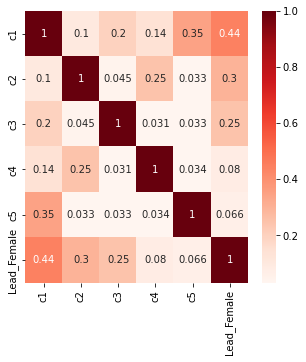

In [35]:
# Correlation heatmap (using Pearson correlation)
plt.figure(figsize=(5,5))
correlation = comb_data.corr().abs()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds) # Correlation heatmap using Seaborn
plt.show()

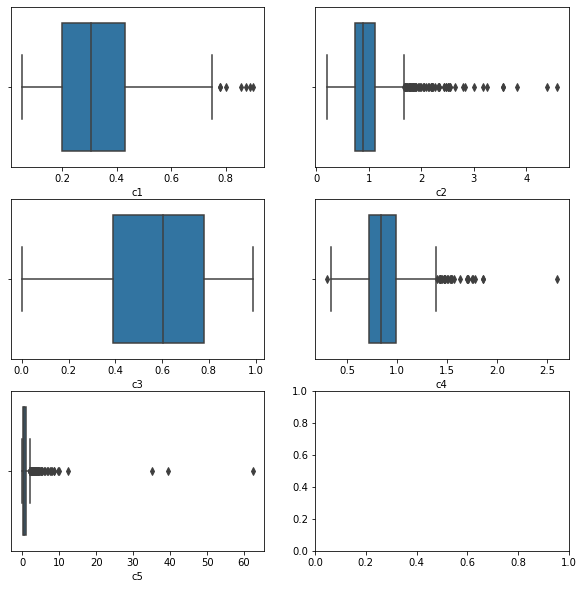

In [36]:
# Box-plot of selected features
def plot_boxplots(X):
    fig, axes = plt.subplots(3, 2, figsize=(10,10))
    i, j = 0, 0

    for col in X_new.columns:
        sns.boxplot(ax=axes[i, j], x=X[col])
        j+=1
        if j > 1:
            i += 1
            j = 0
plot_boxplots(comb_data.iloc[:,:-1])

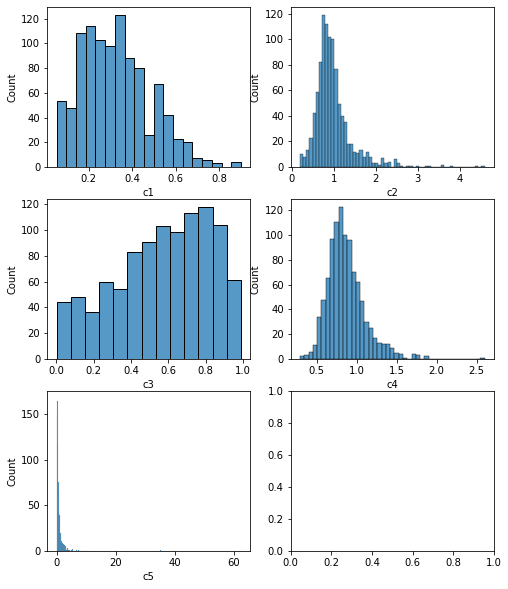

In [37]:
# Histogram of selected features
def plot_histograms(X):
    fig, axes = plt.subplots(3, 2, figsize=(8,10))
    i, j = 0, 0

    for col in X.columns:
        sns.histplot(ax=axes[i, j], x=X[col])
        j+=1
        if j > 1:
            i += 1
            j = 0
plot_histograms(comb_data.iloc[:,:-1])

### Functions for different outlier removal methods
(And testing the results)

In [38]:
def test_outlier_results(new_data): # Test the model after the outlier removal and show results
    X_new = new_data.iloc[:,:-1].copy()
    y_new = new_data['Lead_Female'].copy()
    results = run_model(X_new, y_new)
    print("Best score: ", results.best_score_)
    print(f"Rows removed: {len(comb_data) - len(X_new)}")
    print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )
    print("Best parameters: ", results.best_params_)

def isolationforest_outlier_removal(data):
    clf = skl_ens.IsolationForest(random_state=0)
    outlier_index = clf.fit_predict(data.iloc[:,:-1])
    new_data = data[outlier_index == 1].copy()
    test_outlier_results(new_data)
    return new_data

def ellipticenvelope_outlier_removal(data):
    ee = skl_cv.EllipticEnvelope()
    outlier_index = ee.fit_predict(data.iloc[:,:-1])
    new_data = data[outlier_index == 1].copy()
    test_outlier_results(new_data)
    return new_data

def localoutlierfactor_outlier_removal(data, n_neighbors=20):
    lof = skl_nb.LocalOutlierFactor(n_neighbors=n_neighbors)
    outlier_index = lof.fit_predict(data.iloc[:,:-1])
    new_data = data[outlier_index == 1].copy()
    test_outlier_results(new_data)
    return new_data

def oneclasssvm_outlier_removal(data, nu=0.5):
    ocs = skl_sv.OneClassSVM(nu=nu)
    outlier_index = ocs.fit_predict(data.iloc[:,:-1])
    new_data = data[outlier_index == 1].copy()
    test_outlier_results(new_data)
    return new_data

### We apply the different sci-kit outlier functions
We review which give the best results without dropping so much rows, as the training values are important for making the predictions

In [39]:
new_data = isolationforest_outlier_removal(comb_data)

Best score:  0.9042398119122257
Rows removed: 142
Std deviation of best result:  0.027244161971254073
Best parameters:  {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1}


In [40]:
new_data = ellipticenvelope_outlier_removal(comb_data)

Best score:  0.9053726708074534
Rows removed: 102
Std deviation of best result:  0.022366619129336157
Best parameters:  {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1}


In [41]:
new_data = localoutlierfactor_outlier_removal(comb_data, n_neighbors=25)

Best score:  0.9005047250859107
Rows removed: 44
Std deviation of best result:  0.024636351940268128
Best parameters:  {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 6, 'kneighborsclassifier__p': 1}


In [42]:
new_data = oneclasssvm_outlier_removal(comb_data, nu=0.4)

Best score:  0.8901803278688525
Rows removed: 405
Std deviation of best result:  0.028729630192362
Best parameters:  {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 17, 'kneighborsclassifier__p': 1}


### Choosing LocalOutlierFactor
While ellipticenvelope shows slightly better results, the advantage of local outlierf factor is that it doesn't drop so many records. As predictions in K-nn rely on the training dataset, it's best if we don't lose this information.
Additionally, Local Outlier Factor uses the principles of k-nn to determine outliers: it identifies them depending on how much an element is isolated with respecto to its neighbors.

After processing the dataset with LocalOutlierFactor, the features seem better distributed in the histogram.

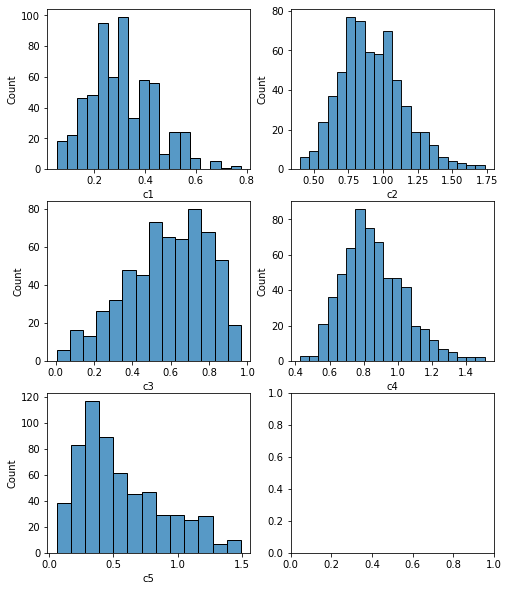

In [43]:
plot_histograms(new_data.iloc[:,:-1])

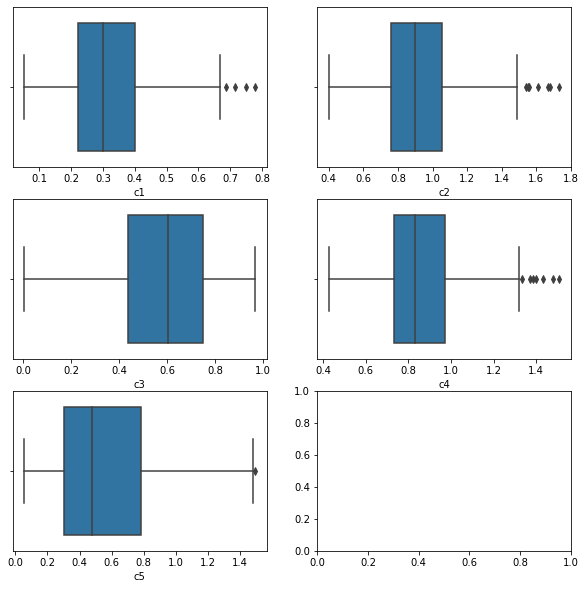

In [44]:
plot_boxplots(new_data.iloc[:,:-1])

## Testing what happens if we remove outliers before combining features

In [45]:
data_copy = data_w_dummies.iloc[:,:-1].copy() # Dataset excluding dummy variable 'Lead_male'
new_data2 = localoutlierfactor_outlier_removal(data_copy)

Best score:  0.8078222222222223
Rows removed: 16
Std deviation of best result:  0.020292294865165105
Best parameters:  {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__p': 1}


In [46]:
# Adjust possible 0 values that could create division by 0 in combined features
new_data2.loc[new_data2['Number of female actors'] == 0, ['Number of female actors']] = 1
new_data2.loc[new_data2['Age Lead'] == 0, ['Age Lead']] = 1
new_data2.loc[new_data2['Number of words lead'] == 0, ['Number of words lead']] = 1
new_data2.loc[new_data2['Mean Age Male'] == 0, ['Mean Age Male']] = 1
new_data2.loc[new_data2['Number words male'] == 0, ['Number words male']] = 1

# Add combined features
new_data2['c1'] = new_data2['Number of female actors']/(new_data2['Number of female actors'] + new_data2['Number of male actors'])
new_data2['c2'] = new_data2['Age Co-Lead']/new_data2['Age Lead']
new_data2['c3'] = new_data2['Difference in words lead and co-lead']/new_data2['Number of words lead']
new_data2['c4'] = new_data2['Mean Age Female']/new_data2['Mean Age Male']
new_data2['c5'] = new_data2['Number words female']/new_data2['Number words male']

new_data2 = new_data2[['c1', 'c2', 'c3', 'c4', 'c5', 'Lead_Female']].copy()
X_new2 = new_data2[['c1', 'c2', 'c3', 'c4', 'c5']].copy()
y_new2 = new_data2['Lead_Female'].copy()

In [47]:
results = run_model(X_new2, y_new2)
print("Best score: ", results.best_score_)
print("Std deviation of best result: ", 
      results.cv_results_['std_test_score'][results.best_index_] )

Best score:  0.8965030303030302
Std deviation of best result:  0.026510222841588934


Removing outliers before combining features seems to give very similar results. Around .06% lower results, although only removing 16 records from the dataset.

# 6. Final GridSearch increasing the parameter range
We do a more thorough gridsearch, to see if the scores and recomended hyperparameters remain similar.

In [48]:
final_data = localoutlierfactor_outlier_removal(comb_data, n_neighbors=25)

X_final = final_data.iloc[:,:-1]
y_final = final_data['Lead_Female']

Best score:  0.9005047250859107
Rows removed: 44
Std deviation of best result:  0.024636351940268128
Best parameters:  {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 6, 'kneighborsclassifier__p': 1}


In [49]:
n_neighbors = list(range(1,60))
leaf_size = list(range(1,20))
p=[1,2]
results_final = run_model(X_final, y_final, n_neighbors=n_neighbors, leaf_size=leaf_size, p=p, n_splits=10, n_repeats=5)

In [50]:
print("Best score: ", results_final.best_score_)
print("Best parameters: ")
results_final.best_params_

Best score:  0.9005047250859107
Best parameters: 


{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 6,
 'kneighborsclassifier__p': 1}

In [51]:
print("Std deviation of best result: ", 
      results_final.cv_results_['std_test_score'][results.best_index_] )

Std deviation of best result:  0.0267864436394439


# 7. Model evaluation
Evaluation of the method based on the best parameters found

In [52]:
class WithoutOutliersClassifier(skl_ba.BaseEstimator, skl_ba.ClassifierMixin):
    def __init__(self, outlier_detector, classifier):
        self.outlier_detector = outlier_detector
        self.classifier = classifier

    def fit(self, X, y):
        self.outlier_detector_ = skl_ba.clone(self.outlier_detector)
        mask = self.outlier_detector_.fit_predict(X, y) == 1
        self.classifier_ = skl_ba.clone(self.classifier).fit(X[mask], y[mask])
        print(len(X))
        print(len(X[mask]))
        return self

    def predict(self, X):
        return self.classifier_.predict(X)
    
    def predict_proba(self, X):
        return self.classifier_.predict_proba(X) 
    
    def decision_function(self, X):
        return self.predict_proba(X)[:,1]        

In [53]:
def produce_evaluation(x_array, y_array):

    knn_m = skl_nb.KNeighborsClassifier(leaf_size=1, n_neighbors=6, p=1)
    
    lof = skl_nb.LocalOutlierFactor(n_neighbors=20)

    woc = WithoutOutliersClassifier(lof, knn_m)

    sc = skl_pre.StandardScaler()

    pipeline = skl_pl.Pipeline([
                 ('preprocess',sc),
                ('model', woc)
            ])

    metrics = {
               'accuracy': 'accuracy',
                'f1': skl_me.make_scorer(skl_me.f1_score),
               'roc_auc':  'roc_auc',
               'precision':skl_me.make_scorer(skl_me.precision_score),
               'recall': skl_me.make_scorer(skl_me.recall_score)}

    cv = skl_ms.RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=10)

    result = skl_ms.cross_validate(pipeline, x_array, y_array, scoring=metrics, cv=cv, n_jobs=-1)

    labels = []
    avg = []
    std = []

    for m in metrics:
        values = result["test_" + m]
        labels.append(m)
        avg.append(np.mean(values))
        std.append(np.std(values))

    return pd.DataFrame({"Metric":labels, "Average":avg, "Std dev":std})

In [ ]:
eval_df = produce_evaluation(X_final, y_final)

In [55]:
print(eval_df)

      Metric   Average   Std dev
0   accuracy  0.899272  0.023903
1         f1  0.736481  0.073525
2    roc_auc  0.920941  0.031290
3  precision  0.895177  0.075026
4     recall  0.632684  0.092035
